In [1]:
# CELL: imports and small helpers
import os, glob, math, random
from pathlib import Path
import numpy as np
import mne
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cpu


fix for compativility for mne and NUmpy


In [2]:
# ---- compatibility patch for MNE + NumPy 2.0 ----
import numpy as np
import mne

if hasattr(np, "fromstring"):
    _orig = np.fromstring
    def _safe_fromstring(string, dtype=float, sep=""):
        try:
            return _orig(string, dtype=dtype, sep=sep)
        except ValueError:
            # fallback for numpy>=2 where binary mode removed
            if isinstance(string, str):
                string = string.encode()  # convert to bytes
            return np.frombuffer(string, dtype=dtype)
    np.fromstring = _safe_fromstring
print("✅ Applied NumPy<->MNE compatibility patch")


✅ Applied NumPy<->MNE compatibility patch


In [3]:
DATA_ROOT = "BCICIV_2a_gdf"   # <- adjust to your path
TRAIN_PATTERN = os.path.join(DATA_ROOT, "A*T.gdf")
TEST_PATTERN  = os.path.join(DATA_ROOT, "A*E.gdf")

# Preprocessing params (paper used 128 Hz -> 4s -> 512)
TARGET_SFREQ = 128.0
TMIN, TMAX = 0.0, 4.0
NT = int((TMAX - TMIN) * TARGET_SFREQ)  # expected 512
BATCH = 32
EPOCHS = 120          # can reduce during debugging
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 12         # early stopping patience
RHO_W_UPDATE = 0.001  # keep consistent with paper logic for W update if used
SEED = 42

os.makedirs("models", exist_ok=True)


In [4]:
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

from tqdm.notebook import tqdm


In [5]:
# CELL: loader function for BCICIV_2a gdf files
def load_bci_gdf(file_path, picks=None, l_freq=0.5, h_freq=40.0,
                 target_sfreq=TARGET_SFREQ, tmin=TMIN, tmax=TMAX):
    # Returns X: (n_trials, n_channels, nt), y: (n_trials,), ch_names
    raw = mne.io.read_raw_gdf(file_path, preload=True, verbose=False)
    # events and event_id from annotations
    try:
        events, event_id = mne.events_from_annotations(raw, verbose=False)
    except Exception:
        events = []
        event_id = {}
    # BCICIV 2a typical MI labels mapping (depends on file metadata)
    # usually: 1=left hand, 2=right hand, 3=foot, 4=tongue (but we will select left/right)
    raw.filter(l_freq, h_freq, verbose=False)
    if abs(raw.info['sfreq'] - target_sfreq) > 1e-3:
        raw.resample(target_sfreq, npad='auto', verbose=False)
    picks_idx = mne.pick_types(raw.info, eeg=True, exclude='bads') if picks is None else picks
    ch_names = [raw.ch_names[i] for i in picks_idx]
    nt = int((tmax - tmin) * target_sfreq)
    Xs, ys = [], []
    for ev in events:
        onset_sample = int(ev[0])
        code = int(ev[2])
        # keep only left (1) and right (2)
        if code not in (1, 2):
            continue
        start = int(onset_sample + tmin * raw.info['sfreq'])
        stop  = int(onset_sample + tmax * raw.info['sfreq'])
        if start < 0 or stop > raw.n_times:
            continue
        data = raw.get_data(picks=picks_idx, start=start, stop=stop)
        # ensure NT
        if data.shape[1] != nt:
            if data.shape[1] > nt:
                data = data[:, :nt]
            else:
                pad = np.zeros((len(picks_idx), nt - data.shape[1]))
                data = np.hstack([data, pad])
        lbl = 0 if code == 1 else 1  # left=0, right=1
        Xs.append(data.astype(np.float32))
        ys.append(lbl)
    if len(Xs) == 0:
        return np.zeros((0, len(picks_idx), nt), dtype=np.float32), np.zeros((0,), dtype=int), ch_names
    return np.stack(Xs, axis=0), np.array(ys, dtype=int), ch_names


In [6]:
# CELL: build datasets by reading all *T.gdf files for train and *E.gdf for test
train_files = sorted(glob.glob(TRAIN_PATTERN))
test_files  = sorted(glob.glob(TEST_PATTERN))
assert len(train_files) > 0 and len(test_files) > 0, f"No gdf files found in {DATA_ROOT}"

X_train_list, y_train_list = [], []
for f in train_files:
    Xf, yf, chs = load_bci_gdf(f)
    print(f"Loaded {f}: X {Xf.shape}, y {yf.shape}")
    if Xf.shape[0] > 0:
        X_train_list.append(Xf); y_train_list.append(yf)
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
print("Combined TRAIN shape:", X_train.shape, y_train.shape, "channels:", len(chs))

X_test_list, y_test_list = [], []
for f in test_files:
    Xf, yf, _ = load_bci_gdf(f)
    print(f"Loaded {f}: X {Xf.shape}, y {yf.shape}")
    if Xf.shape[0] > 0:
        X_test_list.append(Xf); y_test_list.append(yf)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
print("Combined TEST shape:", X_test.shape, y_test.shape)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A01T.gdf: X (10, 25, 512), y (10,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A02T.gdf: X (6, 25, 512), y (6,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A03T.gdf: X (9, 25, 512), y (9,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A04T.gdf: X (7, 25, 512), y (7,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A05T.gdf: X (10, 25, 512), y (10,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A06T.gdf: X (25, 25, 512), y (25,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A07T.gdf: X (11, 25, 512), y (11,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A08T.gdf: X (12, 25, 512), y (12,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A09T.gdf: X (28, 25, 512), y (28,)
Combined TRAIN shape: (118, 25, 512) (118,) channels: 25


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A01E.gdf: X (6, 25, 512), y (6,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A02E.gdf: X (5, 25, 512), y (5,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A03E.gdf: X (8, 25, 512), y (8,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A04E.gdf: X (33, 25, 512), y (33,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A05E.gdf: X (11, 25, 512), y (11,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A06E.gdf: X (43, 25, 512), y (43,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A07E.gdf: X (5, 25, 512), y (5,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A08E.gdf: X (8, 25, 512), y (8,)


c:\Users\Sujal Bhatu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Loaded BCICIV_2a_gdf\A09E.gdf: X (8, 25, 512), y (8,)
Combined TEST shape: (127, 25, 512) (127,)


Quick sanity plots (one trial)

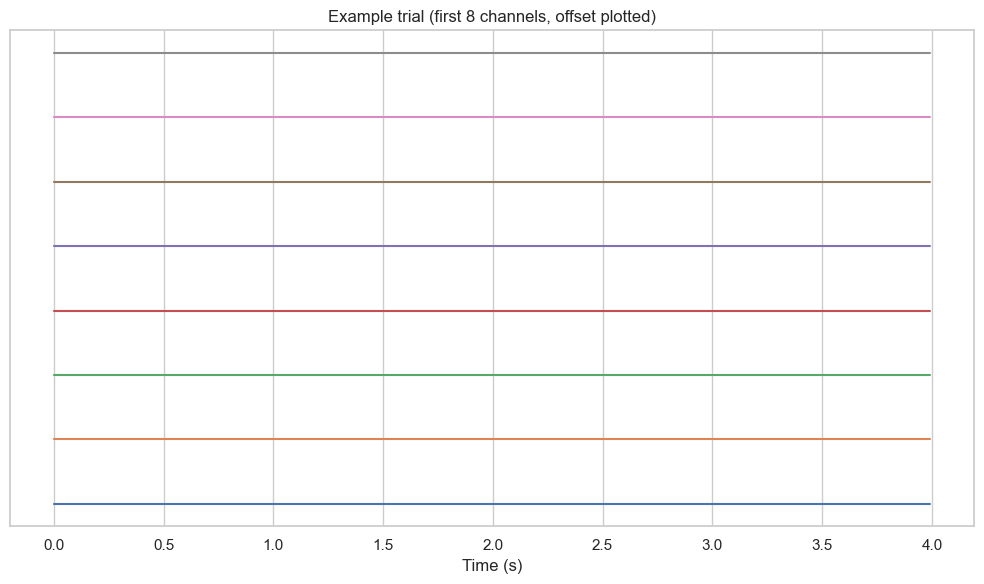

In [7]:
# CELL: plot a random trial (multi-channel)
plt.figure(figsize=(10,6))
trial = 0
t = np.arange(X_train.shape[2]) / TARGET_SFREQ
for i in range(min(8, X_train.shape[1])):
    plt.plot(t, X_train[trial,i] + i*50, label=chs[i])  # offset for visibility
plt.title("Example trial (first 8 channels, offset plotted)")
plt.xlabel("Time (s)")
plt.yticks([])
plt.tight_layout()


In [9]:
# CELL: model definition (improved)
class TFEMBlock(nn.Module):
    def __init__(self, nch, F=16, k_t=15, pool=False, pool_k=4, drop=0.25):
        super().__init__()
        pad_t = (k_t - 1) // 2
        self.conv = nn.Conv2d(1, F, kernel_size=(1, k_t), padding=(0, pad_t))
        self.bn = nn.BatchNorm2d(F)
        self.pw = nn.Conv2d(F, 1, kernel_size=1)
        self.pool = nn.AvgPool2d((1, pool_k)) if pool else None
        self.elu = nn.ELU()
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        # x: (b, nch, t)
        b,nch,t = x.shape
        x = x.unsqueeze(1)  # (b,1,nch,t)
        x = self.conv(x)
        x = self.bn(x)
        x = self.elu(x)
        x = self.pw(x)
        if self.pool:
            x = self.pool(x)
        x = self.drop(x)
        return x.squeeze(1)

class CARM(nn.Module):
    def __init__(self, Wref, tdim, drop=0.25):
        super().__init__()
        self.Wref = Wref
        self.Theta = nn.Parameter(torch.randn(tdim, tdim) * 0.01)
        self.elu = nn.ELU()
        self.drop = nn.Dropout(drop)
    def forward(self,x):
        # x: (b, nch, t)
        h = torch.einsum('ij,bjf->bif', self.Wref, x)
        out = torch.einsum('bif,fg->big', h, self.Theta)
        out = self.elu(out)
        out = self.drop(out)
        return out

class EEG_ARNN(nn.Module):
    def __init__(self, nch, T0, ncls=2, F=16, pool_k=4, rho=0.001):
        super().__init__()
        self.nch=nch; self.T0=T0; self.ncls=ncls; self.rho=rho
        W0 = torch.ones(nch,nch) - torch.eye(nch)
        Wt = W0 + torch.eye(nch)
        D = Wt.sum(dim=1)
        Dinv = torch.diag(1.0 / torch.sqrt(D + 1e-12))
        self.W = nn.Parameter(Dinv @ Wt @ Dinv)
        # TFEM + CARM blocks
        self.tf1 = TFEMBlock(nch, F=F, k_t=15, pool=False)
        self.c1  = CARM(self.W, tdim=T0)
        self.tf2 = TFEMBlock(nch, F=F, k_t=15, pool=True, pool_k=pool_k)
        T2 = T0 // pool_k
        self.c2  = CARM(self.W, tdim=T2)
        self.tf3 = TFEMBlock(nch, F=F, k_t=15, pool=True, pool_k=pool_k)
        T3 = T2 // pool_k
        self.c3  = CARM(self.W, tdim=T3)
        # Fusion + classifier (smaller final fc)
        self.fuse = nn.Conv2d(1,16,kernel_size=(nch,1))
        self.bn = nn.BatchNorm2d(16)
        self.drop = nn.Dropout(0.25)
        self.elu = nn.ELU()
        self.fc = nn.Linear(16*T3, ncls)
    def forward(self,x):
        # x (b,nch,t)
        x = self.tf1(x); x = self.c1(x)
        x = self.tf2(x); x = self.c2(x)
        x = self.tf3(x); x = self.c3(x)
        x = x.unsqueeze(1)  # (b,1,nch,t3)
        x = self.fuse(x)
        x = self.bn(x)
        x = self.elu(x)
        x = self.drop(x)
        x = x.squeeze(2)  # (b,oc,t3)
        b,oc,t = x.shape
        x = x.view(b, oc*t)
        return self.fc(x)


In [10]:
# CELL: create Torch Datasets; add simple augmentations for training
class EEGDataset(Dataset):
    def __init__(self, X, y, augment=False, noise_std=0.01, chan_dropout=0.0):
        self.X = X
        self.y = y
        self.augment = augment
        self.noise_std = noise_std
        self.chan_dropout = chan_dropout
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx].copy()
        y = int(self.y[idx])
        if self.augment:
            if self.noise_std > 0:
                x = x + np.random.normal(0, self.noise_std, x.shape).astype(np.float32)
            if self.chan_dropout > 0:
                drop_mask = np.random.rand(x.shape[0]) > self.chan_dropout
                x = x * drop_mask[:,None]
        return torch.tensor(x).float(), torch.tensor(y).long()

train_ds = EEGDataset(X_train, y_train, augment=True, noise_std=0.005, chan_dropout=0.05)
test_ds  = EEGDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


torch.__version__ = 2.8.0+cpu
ReduceLROnPlateau signature: (optimizer: 'Optimizer', mode: "Literal['min', 'max']" = 'min', factor: 'float' = 0.1, patience: 'int' = 10, threshold: 'float' = 0.0001, threshold_mode: "Literal['rel', 'abs']" = 'rel', cooldown: 'int' = 0, min_lr: 'Union[list[float], float]' = 0, eps: 'float' = 1e-08)
Scheduler created. supports_verbose: False
Epoch 1/120 | train_loss=0.5106 | train_acc=0.9375 | test_acc=0.9291 | lr=0.001000
  ** New best model saved (test acc=0.9291)
Epoch 2/120 | train_loss=0.2230 | train_acc=0.9167 | test_acc=0.9291 | lr=0.001000
Epoch 3/120 | train_loss=0.3227 | train_acc=0.9479 | test_acc=0.9291 | lr=0.001000
Epoch 4/120 | train_loss=0.2472 | train_acc=0.9167 | test_acc=0.9291 | lr=0.001000
Epoch 5/120 | train_loss=0.2890 | train_acc=0.9375 | test_acc=0.9291 | lr=0.001000
Epoch 6/120 | train_loss=0.2671 | train_acc=0.9271 | test_acc=0.9291 | lr=0.001000
Epoch 7/120 | train_loss=0.3331 | train_acc=0.9271 | test_acc=0.9291 | lr=0.001000
Ep

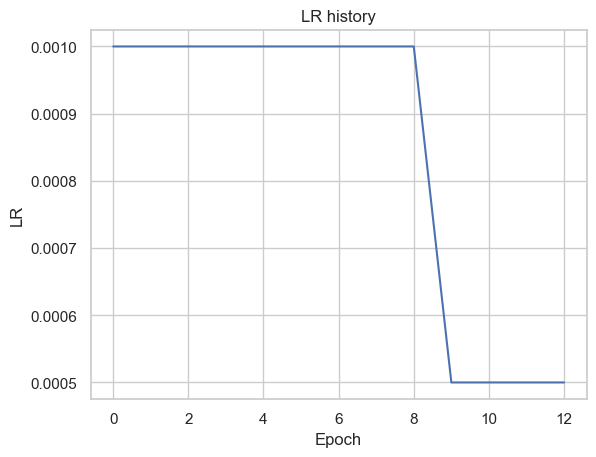

In [12]:
# CELL: improved training loop with robust ReduceLROnPlateau handling

import inspect

# show torch version + scheduler signature (helpful for debugging)
print("torch.__version__ =", torch.__version__)
try:
    print("ReduceLROnPlateau signature:", inspect.signature(torch.optim.lr_scheduler.ReduceLROnPlateau))
except Exception as e:
    print("Could not inspect signature:", e)

# instantiate model, optimizer, scheduler, criterion (same as before)
model = EEG_ARNN(nch=X_train.shape[1], T0=X_train.shape[2], ncls=2).to(device)

# Exclude W param from optimizer (we update W manually)
params = [p for n,p in model.named_parameters() if n!='W' and p.requires_grad]
opt = torch.optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
crit = nn.CrossEntropyLoss()

# Create ReduceLROnPlateau in a compatibility-safe way
try:
    # try the verbose kwarg (some versions accept it)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=6, verbose=True)
    sched_supports_verbose = True
except TypeError:
    # fallback: create scheduler without verbose kwarg
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=6)
    sched_supports_verbose = False

print("Scheduler created. supports_verbose:", sched_supports_verbose)

# helper to get current LR
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

# training variables
best_val_acc = 0.0
best_state = None
train_losses, val_accs, train_accs = [], [], []
es_wait = 0
lr_history = []

for ep in range(1, EPOCHS+1):
    # train
    tloss = train_one_epoch(model, train_loader, opt, crit)
    preds_tr, ytr = evaluate(model, train_loader)
    tracc = accuracy_score(ytr, preds_tr)

    # evaluation on test set
    preds_va, yva = evaluate(model, test_loader)
    vacc = accuracy_score(yva, preds_va)

    train_losses.append(tloss)
    train_accs.append(tracc)
    val_accs.append(vacc)
    lr_history.append(get_lr(opt))

    print(f"Epoch {ep}/{EPOCHS} | train_loss={tloss:.4f} | train_acc={tracc:.4f} | test_acc={vacc:.4f} | lr={get_lr(opt):.6f}")

    # step scheduler (ReduceLROnPlateau expects the metric; we use train loss here)
    prev_lr = get_lr(opt)
    sched.step(tloss)   # we feed tloss (you could use validation loss if you compute it)
    new_lr = get_lr(opt)

    # if scheduler doesn't print, we log LR changes ourselves
    if not sched_supports_verbose and new_lr != prev_lr:
        print(f"  >> ReduceLROnPlateau reduced LR: {prev_lr:.6f} -> {new_lr:.6f}")

    # early stopping on validation accuracy
    if vacc > best_val_acc:
        best_val_acc = vacc
        best_state = {'model': model.state_dict(), 'opt': opt.state_dict(), 'epoch': ep}
        es_wait = 0
        torch.save(best_state, "models/best_eeg_arnn.pth")
        print(f"  ** New best model saved (test acc={best_val_acc:.4f})")
    else:
        es_wait += 1
        if es_wait >= PATIENCE:
            print("Early stopping triggered.")
            break

print("Training finished. Best test accuracy:", best_val_acc)
# optionally plot lr history
import matplotlib.pyplot as plt
plt.plot(lr_history)
plt.title("LR history")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.show()


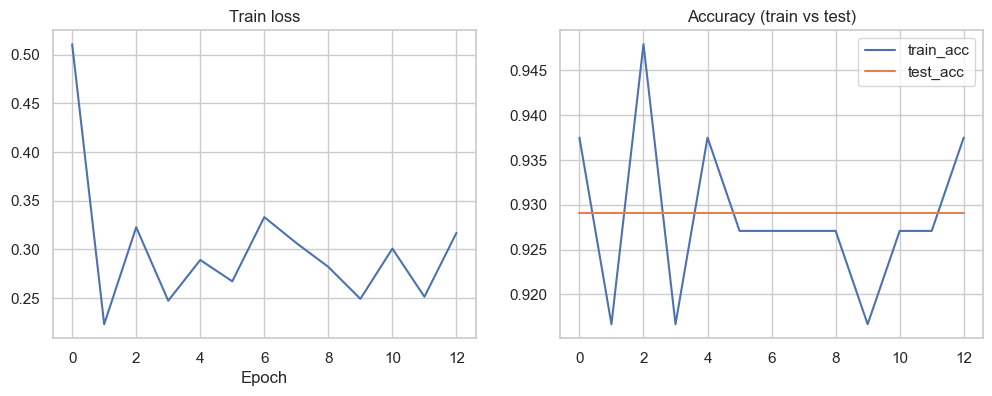

In [13]:
# CELL: plot loss & accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.title("Train loss")
plt.xlabel("Epoch")
plt.subplot(1,2,2)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='test_acc')
plt.legend(); plt.title("Accuracy (train vs test)")
plt.show()


Test accuracy: 0.9291338582677166


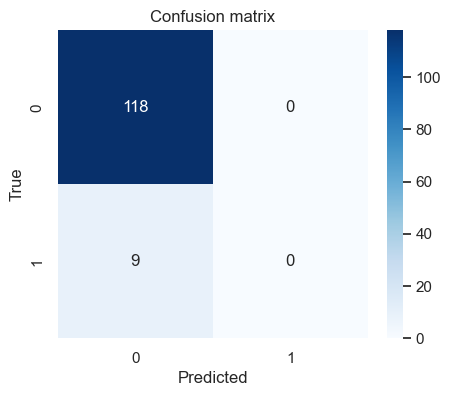

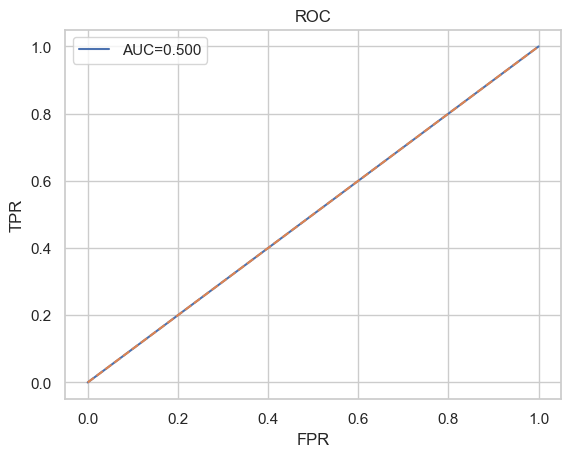

In [14]:
# CELL: test metrics
# load best model
state = torch.load("models/best_eeg_arnn.pth", map_location=device)
model.load_state_dict(state['model'])
preds, ytrue = evaluate(model, test_loader)
acc = accuracy_score(ytrue, preds)
cm = confusion_matrix(ytrue, preds)
print("Test accuracy:", acc)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix")
plt.show()

# ROC/AUC (per-class / binary)
probs = []
model.eval()
with torch.no_grad():
    for xb,yb in test_loader:
        xb=xb.to(device)
        out = model(xb)
        probs.append(F.softmax(out, dim=1)[:,1].cpu().numpy())
probs = np.concatenate(probs)
fpr,tpr,_ = roc_curve(ytrue, probs)
auc = roc_auc_score(ytrue, probs)
plt.figure()
plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.legend(); plt.show()


Top channels (indices): [ 1  8 10  3 16  9 17  7  4 18 23 20 19  0 14 22  2 15  6 12]


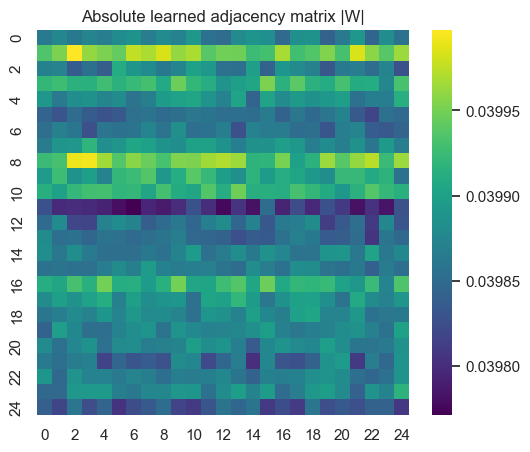

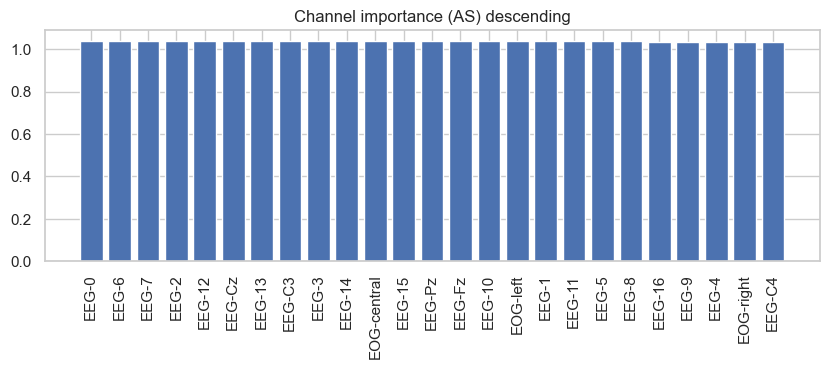

In [15]:
# CELL: channel importance via AS: tau_i = sum_j |W_ij| + diag(W)_i
W_trained = model.W.detach().cpu().numpy()
tau = np.sum(np.abs(W_trained), axis=1) + np.diag(W_trained)
order = np.argsort(-tau)
print("Top channels (indices):", order[:20])
# heatmap of adjacency
plt.figure(figsize=(6,5))
sns.heatmap(np.abs(W_trained), cmap='viridis')
plt.title("Absolute learned adjacency matrix |W|")
plt.show()
# bar plot of tau
plt.figure(figsize=(10,3))
plt.bar(range(len(tau)), tau[order])
plt.xticks(range(len(tau)), [chs[i] for i in order], rotation=90)
plt.title("Channel importance (AS) descending")
plt.show()


In [16]:
# CELL: select top-k channels and retrain a small EEG-ARNN (or simple classifier)
def select_topk_AS(W, k):
    tau = np.sum(np.abs(W), axis=1) + np.diag(W)
    return np.argsort(-tau)[:k].tolist()

k = 20   # choose e.g. 10,20,30 — experiment
topk_idx = select_topk_AS(W_trained, k)
print("Top-k selected channels:", [chs[i] for i in topk_idx])

# prepare reduced data
Xtr_k = X_train[:, topk_idx, :]
Xte_k = X_test[:, topk_idx, :]
# dataset loaders
ds_tr_k = EEGDataset(Xtr_k, y_train, augment=True, noise_std=0.005)
ds_te_k = EEGDataset(Xte_k, y_test, augment=False)
ldr_tr_k = DataLoader(ds_tr_k, batch_size=BATCH, shuffle=True, drop_last=True)
ldr_te_k = DataLoader(ds_te_k, batch_size=BATCH, shuffle=False)

# retrain smaller model with nch=k
model_k = EEG_ARNN(nch=k, T0=Xtr_k.shape[2], ncls=2).to(device)
params_k = [p for n,p in model_k.named_parameters() if n!='W' and p.requires_grad]
opt_k = torch.optim.AdamW(params_k, lr=LR, weight_decay=WEIGHT_DECAY)
crit = nn.CrossEntropyLoss()
best_acc_k = 0.0
for ep in range(1, 61):
    train_one_epoch(model_k, ldr_tr_k, opt_k, crit)
    preds_k, yk = evaluate(model_k, ldr_te_k)
    acck = accuracy_score(yk, preds_k)
    if acck > best_acc_k:
        best_acc_k = acck
print(f"Top-{k} retrain test accuracy: {best_acc_k:.4f}")


Top-k selected channels: ['EEG-0', 'EEG-6', 'EEG-7', 'EEG-2', 'EEG-12', 'EEG-Cz', 'EEG-13', 'EEG-C3', 'EEG-3', 'EEG-14', 'EOG-central', 'EEG-15', 'EEG-Pz', 'EEG-Fz', 'EEG-10', 'EOG-left', 'EEG-1', 'EEG-11', 'EEG-5', 'EEG-8']
Top-20 retrain test accuracy: 0.9291


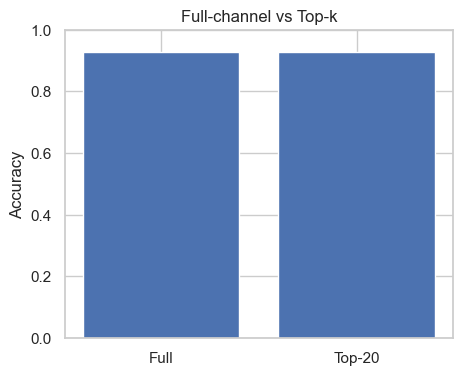

In [17]:
# CELL: compare previously measured accuracies
full_acc = acc
topk_acc = best_acc_k
plt.figure(figsize=(5,4))
plt.bar(['Full','Top-'+str(k)],[full_acc, topk_acc])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Full-channel vs Top-k")
plt.show()


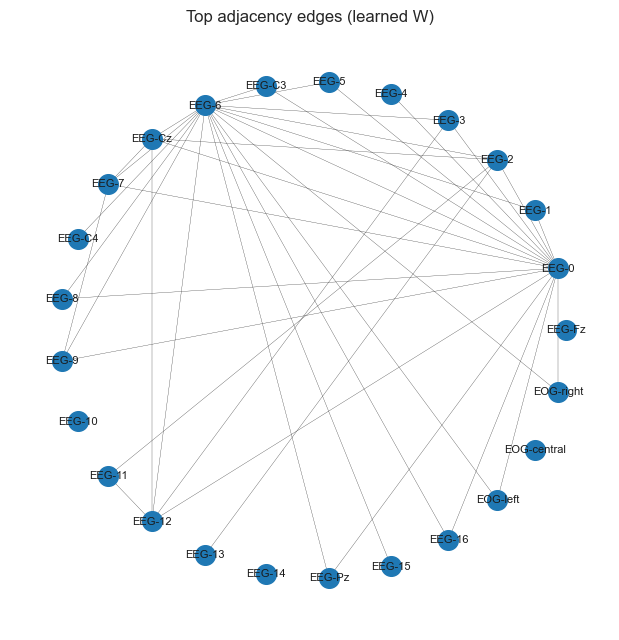

In [18]:
# CELL: (optional) simple network plot of learned W on scalp index positions (requires coords)
# We'll draw a simple network using NetworkX positions: place nodes on a circle
import networkx as nx
G = nx.Graph()
n = W_trained.shape[0]
for i in range(n):
    G.add_node(i, label=chs[i])
# add top edges
absW = np.abs(W_trained)
# keep top M edges
M = 40
flat_idx = np.dstack(np.unravel_index(np.argsort(-absW.ravel()), (n,n)))[0]
edges = []
seen = set()
for (i,j) in flat_idx:
    if i!=j and (i,j) not in seen and (j,i) not in seen:
        edges.append((i,j,absW[i,j]))
        seen.add((i,j))
    if len(edges) >= M:
        break
# add edges with weight attr
for i,j,w in edges:
    G.add_edge(i,j,weight=w)
pos = {i: (math.cos(2*math.pi*i/n), math.sin(2*math.pi*i/n)) for i in range(n)}
plt.figure(figsize=(6,6))
weights = [G[u][v]['weight']*5 for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, labels={i:chs[i] for i in range(n)}, node_size=200, width=weights, font_size=8)
plt.title("Top adjacency edges (learned W)")
plt.show()


In [19]:
# CELL: Save final models and results
torch.save({'model': model.state_dict(), 'ch_names': chs}, "models/final_full_model.pth")
torch.save({'model': model_k.state_dict(), 'ch_names': [chs[i] for i in topk_idx]}, "models/final_topk_model.pth")
print("Saved models to models/")


Saved models to models/
